In [1]:
from langchain_chroma import Chroma
from langchain_openai import OpenAIEmbeddings

embedding_function = OpenAIEmbeddings(model='text-embedding-3-large')

vector_store = Chroma (
    embedding_function=embedding_function,
    collection_name='split_1_300_344',
    persist_directory='./split_1_300_344'
)
retriever = vector_store.as_retriever(search_kwargs={'k': 3})

In [2]:
from typing_extensions import List, TypedDict
from langchain_core.documents import Document
from langgraph.graph import StateGraph

class AgentState(TypedDict):
    query: str
    context: List[Document]
    answer: str

graph_builder = StateGraph(AgentState)

In [3]:
# Node는 2가지가 필요
# 1. 문서를 가져오는 retrieve
# 2. 답변을 생성하는 generate

def retrieve(state: AgentState):
    query = state['query']
    docs = retriever.invoke(query)
    return {'context': docs}

In [4]:
# set the LANGSMITH_API_KEY environment variable (create key in settings)
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model='gpt-4o')

In [5]:
from langchain import hub
# prompt는 genereate, rewrite, 문서 관련성 등 프롬포트가 필요하다.
# 따라서 prompt라는 이름으로는 중복 변수 이름이 될 수 있다.
generate_prompt = hub.pull("rlm/rag-prompt")

def generate(state: AgentState):
    context = state['context']
    query = state['query']
    rag_chain = generate_prompt | llm
    response = rag_chain.invoke({'question': query, 'context': context})
    response = llm.invoke(query, context)
    return {'answer': response}

/root/.pyenv/versions/3.11.2/lib/python3.11/site-packages/langsmith/client.py:253: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


In [6]:
from langchain import hub
from typing import Literal
doc_relevance_prompt = hub.pull("langchain-ai/rag-document-relevance")

def check_doc_relevance(state: AgentState) -> Literal['generate', 'rewrite']:
    query = state['query']
    context = state['context']
    print(f'context = {context}')
    doc_relevance_chain = doc_relevance_prompt | llm
    response = doc_relevance_chain.invoke({'question': query, 'documents': context})
    print(f'doc relevance response: {response}')
    if response['Score'] == 1:
        return 'generate'
    return 'rewrite'

/root/.pyenv/versions/3.11.2/lib/python3.11/site-packages/langsmith/client.py:253: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


In [7]:
query = "Bean Factory와 Application Context의 차이는?"
# Bean Factory와 Application Context의 차이" → "FactoryBean과 Application Context의 차이

In [8]:
from langchain_core.prompts import PromptTemplate

dictionary = ['사용자와 관련된 표현 -> 클라이언트']
rewrite_prompt = PromptTemplate.from_template(f"""
사용자의 질문을 보고, 우리의 사전을 참고해서 사용자의 질문을 변경해주세요.
사전: {dictionary}
질문: {{query}}
""")

# 입력된 쿼리(query)를 변형(rewrite)하여 새로운 쿼리를 생성하는 것
def rewrite(state: AgentState):
    query = state['query']
    rewrite_chain = rewrite_prompt | llm
    response = rewrite_chain.invoke({'query': query})
    return {'query': response}

In [9]:
graph_builder.add_node('retrieve', retrieve)
# graph_builder.add_node('check_doc_relevance', check_doc_relevance)
graph_builder.add_node('generate', generate)
graph_builder.add_node('rewrite', rewrite)

In [10]:
from langgraph.graph import START, END

graph_builder.add_edge(START, 'retrieve')
# conditional_edges의 2번째 인자에는 runnable 객체가 들어가야함으로, 직접 함수를 입력
graph_builder.add_conditional_edges('retrieve', check_doc_relevance)
graph_builder.add_edge('rewrite', 'retrieve')
graph_builder.add_edge('generate', END)

In [11]:
graph = graph_builder.compile()

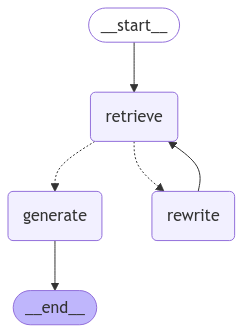

In [12]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [13]:
initial_state = {'query': '스프링 프레임워크는 사용자와 통신할 때, 어떤 규격으로 통신을 하나요?'}
graph.invoke(initial_state)

context = [Document(id='d0d21ede-1bb8-4c83-bd4e-39e34c4dfe63', metadata={'source': './documents/split_1_300_344.txt'}, page_content='Configuring codecs for HttpMessageReader and HttpMessageWriter instances (described later in this document).\nSupport for serving static resources, including support for WebJars (described later in this document).'), Document(id='a64931fc-8bac-408c-80d6-6dfd53d3d3a1', metadata={'source': './documents/split_1_300_344.txt'}, page_content='Configuring codecs for HttpMessageReader and HttpMessageWriter instances (described later in this document).\nSupport for serving static resources, including support for WebJars (described later in this document).'), Document(id='478f2379-23fd-459c-b2f2-fbbc68b6125e', metadata={'source': './documents/split_1_300_344.txt'}, page_content='Configuring codecs for HttpMessageReader and HttpMessageWriter instances (described later in this document).\nSupport for serving static resources, including support for WebJars (described 

TypeError: argument 'text': 'AIMessage' object cannot be converted to 'PyString'